In [3]:
from neuralNet import MatrixNeuralNet
from pdes import LinearQuadraticRegulator2D
import matplotlib.pyplot as plt
import numpy as np
from utils import setLogger

setLogger("training")

In [4]:
layers = [2, 20, 20, 3]
network = MatrixNeuralNet( layers)
gamma = {'data': 0, 'gradient': 0, 'residual': 1}
pde = LinearQuadraticRegulator2D( network, gamma )

lrs = [1e-2, 1e-3]
iterations = [1000, 2000]

resu = pde.train(
    interiorPointCount=10,
    dataPointCount=10,
    lrs=lrs,
    iterations=iterations,
    sampling='random'
    )

2024-07-27 13:56:33,816 - training - INFO - 0 / 3000 (0 / 1000), lr:1.0e-02, loss:5.38e+00 (data: 0.00e+00, grad: 0.00e+00, res: 5.38e+00)
2024-07-27 13:56:35,604 - training - INFO - 1000 / 3000 (0 / 2000), lr:1.0e-03, loss:4.86e-07 (data: 0.00e+00, grad: 0.00e+00, res: 4.86e-07)
2024-07-27 13:56:37,197 - training - INFO - 2000 / 3000 (1000 / 2000), lr:1.0e-03, loss:9.41e-08 (data: 0.00e+00, grad: 0.00e+00, res: 9.41e-08)


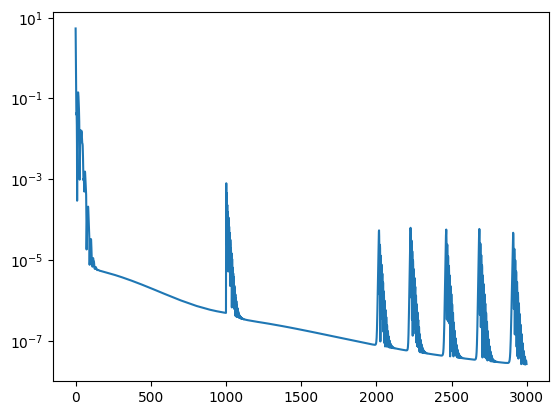

In [5]:
ax = resu['loss'].plot()
ax.set_yscale("log")

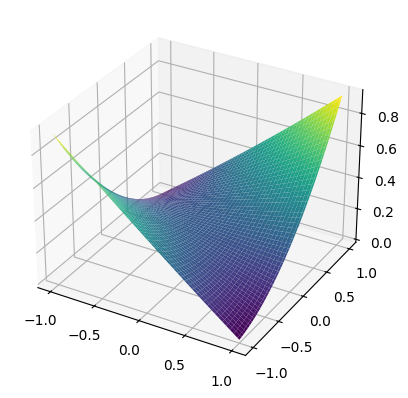

In [6]:
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)

X, Y = np.meshgrid(x, y)
space = pde.getEvaluationPoints() 

Z = pde.network.computeValueFunction(space).reshape(-1, 100) - pde.network.computeValueFunction(space).reshape(-1, 100).min()

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z.detach().cpu().numpy(), cmap='viridis');

# Convex neural net

In [9]:
import torch
import torch.nn as nn

class ConvexNN(nn.Module):
    def __init__(self, input_dim, hidden_dims):
        super(ConvexNN, self).__init__()
        self.layers = nn.ModuleList()
        
        # Input layer
        self.layers.append(nn.Linear(input_dim, hidden_dims[0]))
        
        # Hidden layers
        for i in range(1, len(hidden_dims)):
            self.layers.append(nn.Linear(hidden_dims[i-1], hidden_dims[i]))
        
        # Output layer
        self.layers.append(nn.Linear(hidden_dims[-1], 1))
    
    def forward(self, x):
        for layer in self.layers[:-1]:
            x = torch.relu(layer(x))**2  # Squared ReLU is convex
        return self.layers[-1](x)

# Usage example
model = ConvexNN(input_dim=2, hidden_dims=[10, 10])
x = torch.randn(100, 2)
y = model(x)

In [10]:
import torch
import torch.nn as nn
import numpy as np

def check_global_convexity(model, x_range, y_range, num_points=1000):
    x = np.linspace(x_range[0], x_range[1], num_points)
    y = np.linspace(y_range[0], y_range[1], num_points)
    X, Y = np.meshgrid(x, y)
    
    points = torch.tensor(np.column_stack((X.ravel(), Y.ravel())), dtype=torch.float32, requires_grad=True)
    
    def compute_hessian(model, point):
        z = model(point.unsqueeze(0))
        grad = torch.autograd.grad(z, point, create_graph=True)[0]
        hessian = []
        for g in grad:
            hessian.append(torch.autograd.grad(g, point, retain_graph=True)[0])
        return torch.stack(hessian)
    
    non_convex_points = []
    for i, point in enumerate(points):
        hessian = compute_hessian(model, point)
        eigenvalues = torch.linalg.eigvals(hessian).real
        if not torch.all(eigenvalues >= 0):
            non_convex_points.append(point.detach().numpy())
        
        if i % 1000 == 0:
            print(f"Checked {i}/{len(points)} points")
    
    return len(non_convex_points) == 0, non_convex_points

# Usage
model = ConvexNN(input_dim=2, hidden_dims=[10, 10])
is_convex, non_convex_points = check_global_convexity(model, (-5, 5), (-5, 5))
print(f"Is globally convex: {is_convex}")
if not is_convex:
    print(f"Found {len(non_convex_points)} non-convex points")

Checked 0/1000000 points
Checked 1000/1000000 points
Checked 2000/1000000 points
Checked 3000/1000000 points
Checked 4000/1000000 points
Checked 5000/1000000 points
Checked 6000/1000000 points


KeyboardInterrupt: 

In [19]:
import torch
import torch.nn as nn

class GloballyConvexNN(nn.Module):
    def __init__(self, hidden_dim=64):
        super(GloballyConvexNN, self).__init__()
        self.hidden_dim = hidden_dim

        # Networks to compute the elements of M
        self.net_a = nn.Sequential(
            nn.Linear(2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
        self.net_b = nn.Sequential(
            nn.Linear(2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
        self.net_c = nn.Sequential(
            nn.Linear(2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x):
        # Compute the elements of M
        a = self.net_a(x)**2  # Ensure a ≥ 0
        b = self.net_b(x)
        c = self.net_c(x)**2  # Ensure c ≥ 0

        # Construct M
        M = torch.stack([
            torch.cat([a, b], dim=1),
            torch.cat([b, c], dim=1)
        ], dim=1)

        # Compute V(x, y) = 1/2 * x^T * M * x
        x_reshaped = x.unsqueeze(2)  # Shape: (batch_size, 2, 1)
        V = 0.5 * torch.bmm(torch.bmm(x_reshaped.transpose(1, 2), M), x_reshaped).squeeze()

        return V

    def forward_M(self, x):
        # Compute the elements of M
        a = self.net_a(x)**2  # Ensure a ≥ 0
        b = self.net_b(x)
        c = self.net_c(x)**2  # Ensure c ≥ 0

        # Construct M
        M = torch.stack([
            torch.cat([a, b], dim=1),
            torch.cat([b, c], dim=1)
        ], dim=1)

        return M

# Usage example
model = GloballyConvexNN()
x = torch.randn(100, 2)
V = model(x)

# Check positive semidefiniteness
def is_psd(M):
    return torch.all(torch.linalg.eigvals(M).real >= 0)

M = model.forward_M(x)
print("Is M positive semidefinite?", is_psd(M))

Is M positive semidefinite? tensor(False)


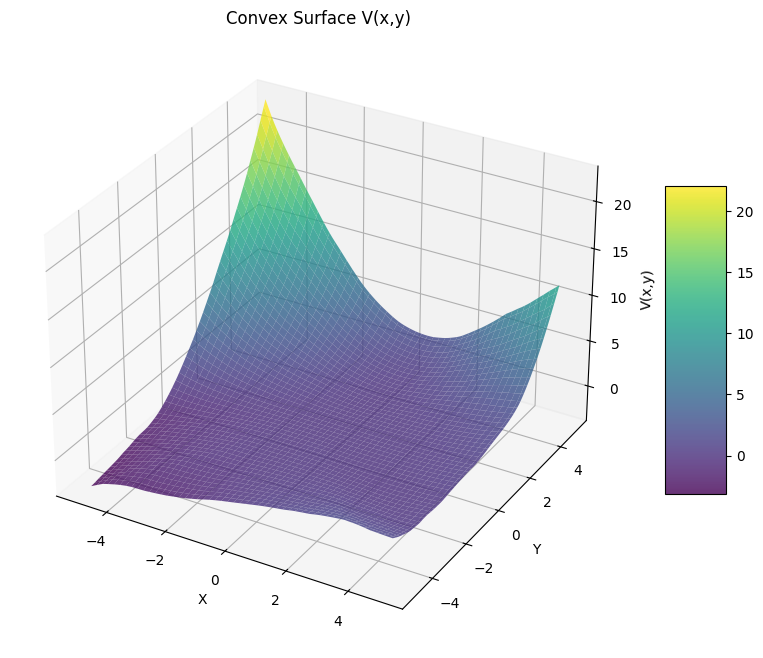

In [22]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_convex_surface(model, x_range=(-5, 5), y_range=(-5, 5), num_points=100):
    """
    Plot the 3D surface of the convex function V(x,y) produced by the model.
    
    Args:
    model: The GloballyConvexNN model
    x_range: Tuple of (min_x, max_x)
    y_range: Tuple of (min_y, max_y)
    num_points: Number of points to sample in each dimension
    """
    x = np.linspace(x_range[0], x_range[1], num_points)
    y = np.linspace(y_range[0], y_range[1], num_points)
    X, Y = np.meshgrid(x, y)
    
    # Prepare input for the model
    xy = torch.tensor(np.column_stack((X.ravel(), Y.ravel())), dtype=torch.float32)
    
    # Compute V(x,y) using the model
    with torch.no_grad():
        V = model(xy).numpy().reshape(X.shape)
    
    # Create the 3D plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot the surface
    surf = ax.plot_surface(X, Y, V, cmap='viridis', edgecolor='none', alpha=0.8)
    
    # Customize the plot
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('V(x,y)')
    ax.set_title('Convex Surface V(x,y)')
    
    # Add a color bar
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
    
    plt.show()

# Usage example
model = GloballyConvexNN()  # Assuming you've already defined and trained your model

# Plot the surface
plot_convex_surface(model)

# Optionally, you can specify custom ranges and resolution
# plot_convex_surface(model, x_range=(-10, 10), y_range=(-10, 10), num_points=200)

In [23]:
import torch
import torch.nn as nn

class GuaranteedPSDConvexNN(nn.Module):
    def __init__(self, hidden_dim=64):
        super(GuaranteedPSDConvexNN, self).__init__()
        self.hidden_dim = hidden_dim

        # Networks to compute the elements of L (Cholesky factor of M)
        self.net_l11 = nn.Sequential(
            nn.Linear(2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
        self.net_l21 = nn.Sequential(
            nn.Linear(2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
        self.net_l22 = nn.Sequential(
            nn.Linear(2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x):
        # Ensure x is 2D: (batch_size, 2)
        if x.dim() == 1:
            x = x.unsqueeze(0)
        
        # Compute the elements of L (lower triangular Cholesky factor)
        l11 = self.net_l11(x).exp()  # Ensure positive
        l21 = self.net_l21(x)
        l22 = self.net_l22(x).exp()  # Ensure positive

        # Construct L
        L = torch.stack([
            torch.cat([l11, torch.zeros_like(l21)], dim=1),
            torch.cat([l21, l22], dim=1)
        ], dim=1)

        # Compute M = L * L^T (guaranteed positive semidefinite)
        M = torch.matmul(L, L.transpose(1, 2))

        # Compute V(x, y) = 1/2 * x^T * M * x
        x_reshaped = x.unsqueeze(2)  # Shape: (batch_size, 2, 1)
        V = 0.5 * torch.bmm(torch.bmm(x_reshaped.transpose(1, 2), M), x_reshaped).squeeze()

        return V

    def forward_M(self, x):
        # Ensure x is 2D: (batch_size, 2)
        if x.dim() == 1:
            x = x.unsqueeze(0)
        
        # Compute the elements of L (lower triangular Cholesky factor)
        l11 = self.net_l11(x).exp()  # Ensure positive
        l21 = self.net_l21(x)
        l22 = self.net_l22(x).exp()  # Ensure positive

        # Construct L
        L = torch.stack([
            torch.cat([l11, torch.zeros_like(l21)], dim=1),
            torch.cat([l21, l22], dim=1)
        ], dim=1)

        # Compute M = L * L^T (guaranteed positive semidefinite)
        M = torch.matmul(L, L.transpose(1, 2))

        return M

# Usage example
model = GuaranteedPSDConvexNN()

# Test with batched input
x_batch = torch.randn(100, 2)
V_batch = model(x_batch)
print("Batched input shape:", x_batch.shape)
print("Batched output shape:", V_batch.shape)
print("First few output values:", V_batch[:5].tolist())

# Check positive semidefiniteness
def is_psd(M):
    return torch.all(torch.linalg.eigvals(M).real >= 0)

M_batch = model.forward_M(x_batch)
print("\nIs M positive semidefinite?", is_psd(M_batch))

# Check individual matrices
for i in range(5):  # Check first 5 matrices
    print(f"Matrix {i} is PSD:", is_psd(M_batch[i]))

Batched input shape: torch.Size([100, 2])
Batched output shape: torch.Size([100])
First few output values: [0.24680331349372864, 0.1928606778383255, 0.6879881024360657, 0.01078877504914999, 0.4136832654476166]

Is M positive semidefinite? tensor(True)
Matrix 0 is PSD: tensor(True)
Matrix 1 is PSD: tensor(True)
Matrix 2 is PSD: tensor(True)
Matrix 3 is PSD: tensor(True)
Matrix 4 is PSD: tensor(True)


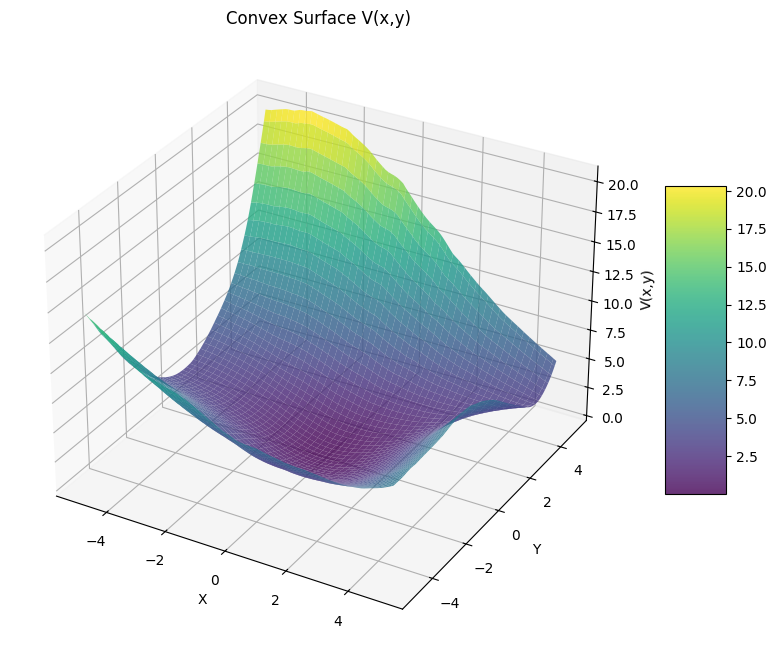

In [24]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_convex_surface(model, x_range=(-5, 5), y_range=(-5, 5), num_points=100):
    """
    Plot the 3D surface of the convex function V(x,y) produced by the model.
    
    Args:
    model: The GloballyConvexNN model
    x_range: Tuple of (min_x, max_x)
    y_range: Tuple of (min_y, max_y)
    num_points: Number of points to sample in each dimension
    """
    x = np.linspace(x_range[0], x_range[1], num_points)
    y = np.linspace(y_range[0], y_range[1], num_points)
    X, Y = np.meshgrid(x, y)
    
    # Prepare input for the model
    xy = torch.tensor(np.column_stack((X.ravel(), Y.ravel())), dtype=torch.float32)
    
    # Compute V(x,y) using the model
    with torch.no_grad():
        V = model(xy).numpy().reshape(X.shape)
    
    # Create the 3D plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot the surface
    surf = ax.plot_surface(X, Y, V, cmap='viridis', edgecolor='none', alpha=0.8)
    
    # Customize the plot
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('V(x,y)')
    ax.set_title('Convex Surface V(x,y)')
    
    # Add a color bar
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
    
    plt.show()

plot_convex_surface(model)

# Optionally, you can specify custom ranges and resolution
# plot_convex_surface(model, x_range=(-10, 10), y_range=(-10, 10), num_points=200)

# Convex network

In [41]:
class ConvexInitialiser:
    """
    Initialisation method for input-convex networks.

    Parameters
    ----------
    var : float, optional
        The target variance fixed point.
        Should be a positive number.
    corr : float, optional
        The target correlation fixed point.
        Should be a value between -1 and 1, but typically positive.
    bias_noise : float, optional
        The fraction of variance to originate from the bias parameters.
        Should be a value between 0 and 1
    alpha : float, optional
        Scaling parameter for leaky ReLU.
        Should be a positive number.

    Examples
    --------
    Default initialisation

    >>> icnn = torch.nn.Sequential(
    ...     torch.nn.Linear(200, 400),
    ...     torch.nn.ReLU(),
    ...     ConvexLinear(400, 300),
    ... )
    >>> torch.nn.init.kaiming_uniform_(icnn[0].weight, nonlinearity="linear")
    >>> torch.nn.init.zeros_(icnn[0].bias)
    >>> convex_init = ConvexInitialiser()
    >>> w1, b1 = icnn[1].parameters()
    >>> convex_init(w1, b1)
    >>> assert torch.all(w1 >= 0) and torch.isclose(b1.var(), torch.zeros(1))

    Initialisation with random bias parameters

    >>> convex_bias_init = ConvexInitialiser(bias_noise=0.5)
    >>> convex_bias_init(w1, b1)
    >>> assert torch.all(w1 >= 0) and b1.var() > 0
    """

    @staticmethod
    @torch.no_grad()
    def init_log_normal_(weight: torch.Tensor, mean_sq: float, var: float) -> torch.Tensor:
        """
        Initialise weights with samples from a log-normal distribution.

        Parameters
        ----------
        weight : torch.Tensor
            The parameter to be initialised.
        mean_sq : float
            The squared mean of the normal distribution underlying the log-normal.
        var : float
            The variance of the normal distribution underlying the log-normal.

        Returns
        -------
        weight : torch.Tensor
            A reference to the inputs that have been modified in-place.
        """
        log_mom2 = math.log(mean_sq + var)
        log_mean = math.log(mean_sq) - log_mom2 / 2.
        log_var = log_mom2 - math.log(mean_sq)
        return torch.nn.init.normal_(weight, log_mean, log_var ** .5).exp_()

    def __init__(self, var: float = 1., corr: float = 0.5,
                 bias_noise: float = 0., alpha: float = 0.):
        self.target_var = var
        self.target_corr = corr
        self.bias_noise = bias_noise
        self.relu_scale = 2. / (1. + alpha ** 2)

    def __call__(self, weight: torch.Tensor, bias: torch.Tensor):
        if bias is None:
            raise ValueError("Principled Initialisation for ICNNs requires bias parameter")

        fan_in = torch.nn.init._calculate_correct_fan(weight, "fan_in")
        weight_dist, bias_dist = self.compute_parameters(fan_in)
        weight_mean_sq, weight_var = weight_dist
        self.init_log_normal_(weight, weight_mean_sq, weight_var)

        bias_mean, bias_var = bias_dist
        torch.nn.init.normal_(bias, bias_mean, bias_var ** .5)

    def compute_parameters(self, fan_in: int) -> tuple[
        tuple[float, float], tuple[float, float] | None
    ]:
        """
        Compute the distribution parameters for the initialisation.

        Parameters
        ----------
        fan_in : int
            Number of incoming connections.

        Returns
        -------
        (weight_mean_sq, weight_var) : tuple of 2 float
            The squared mean and variance for weight parameters.
        (bias_mean, bias_var): tuple of 2 float, optional
            The mean and variance for the bias parameters.
            If `no_bias` is `True`, `None` is returned instead.
        """
        target_mean_sq = self.target_corr / self.corr_func(fan_in)
        target_variance = self.relu_scale * (1. - self.target_corr) / fan_in

        shift = fan_in * (target_mean_sq * self.target_var / (2 * math.pi)) ** .5
        bias_var = 0.
        if self.bias_noise > 0.:
            target_variance *= (1 - self.bias_noise)
            bias_var = self.bias_noise * (1. - self.target_corr) * self.target_var

        return (target_mean_sq, target_variance), (-shift, bias_var)

    def corr_func(self, fan_in: int) -> float:
        """ Helper function for correlation (cf. $f_\mathrm{c}$, eq. 35). """
        rho = self.target_corr
        mix_mom = (1 - rho ** 2) ** .5 + rho * math.acos(-rho)
        return fan_in * (math.pi - fan_in + (fan_in - 1) * mix_mom) / (2 * math.pi)


In [48]:
from abc import ABC, abstractmethod
import copy

import torch
from torch import nn

class TraditionalInitialiser:
    """
    Initialisation for regular networks using variance scaling.
    """

    def __init__(self, gain: float = 1.):
        self.gain = gain

    def __call__(self, weight: torch.Tensor, bias: torch.Tensor):
        fan_in = torch.nn.init._calculate_correct_fan(weight, "fan_in")
        weight_dist, bias_dist = self.compute_parameters(fan_in, bias is None)
        weight_mean_sq, weight_var = weight_dist
        torch.nn.init.normal_(weight, weight_mean_sq ** .5, weight_var ** .5)
        if bias is not None:
            bias_mean, bias_var = bias_dist
            torch.nn.init.normal_(bias, bias_mean, bias_var ** .5)

    def compute_parameters(self, fan_in: int, no_bias: bool = False) -> tuple[
        tuple[float, float], tuple[float, float] | None
    ]:
        return (0., self.gain / fan_in), (0., 0.)

class Positivity(ABC):
    """ Interface for function that makes weights positive. """

    @abstractmethod
    def __call__(self, weight: torch.Tensor) -> torch.Tensor:
        """ Transform raw weight to positive weight. """
        ...

    def inverse_transform(self, pos_weight: torch.Tensor) -> torch.Tensor:
        """ Transform positive weight to raw weight before transform. """
        return self.__call__(pos_weight)

class LazyClippedPositivity(Positivity):
    """
    Make weights positive by clipping negative weights after each update.

    References
    ----------
    Amos et al. (2017)
        Input-Convex Neural Networks.
    """

    def __call__(self, weight):
        with torch.no_grad():
            weight.clamp_(0)

        return weight

class ExponentialPositivity(Positivity):
    """
    Make weights positive by applying exponential function during forward pass.
    """

    def __call__(self, weight):
        return torch.exp(weight)

    def inverse_transform(self, pos_weight):
        return torch.log(pos_weight)


class ConvexLinear(nn.Linear):
    """Linear layer with positive weights."""

    def __init__(self, *args, positivity: Positivity = None, **kwargs):
        if positivity is None:
            raise TypeError("positivity must be given as kwarg for convex layer")

        self.positivity = positivity
        super().__init__(*args, **kwargs)

    def forward(self, x):
        return torch.nn.functional.linear(x, self.positivity(self.weight), self.bias)


In [52]:
def get_model(name: str, num_hidden: int = 128, bad_init: bool = False, skip: bool = False):
    num_in, num_out = 2, 1
    if name == "logreg":
        return nn.Linear(num_in, num_out)

    if name == "fc":
        positivity = NoPositivity()
    elif name == "convex":
        positivity = ExponentialPositivity()
    elif name == "icnn":
        positivity = LazyClippedPositivity()
    else:
        raise ValueError(f"unknown model name: {name}")

    model = nn.Sequential(
        nn.Dropout(p=.7),
        nn.Linear(num_in, num_hidden),
        nn.ReLU(),
        nn.Dropout(p=.5),
        ConvexLinear(num_hidden, num_hidden, positivity=positivity),
        nn.ReLU(),
        nn.Dropout(p=.5),
        ConvexLinear(num_hidden, num_out, positivity=positivity),
    )

    init = TraditionalInitialiser(gain=2.) if name == "fc" or bad_init else ConvexInitialiser()
    for idx in [4, 7]:
        init(model[idx].weight, model[idx].bias)

    if skip:
        new_model = LinearSkip(num_in, num_hidden, model[1:5])
        new_model = LinearSkip(num_in, num_out, nn.Sequential(new_model, *model[5:]))
        model = nn.Sequential(model[0], new_model)

    return model

In [53]:
model = get_model("icnn", bad_init=True)

In [54]:
print(model)

Sequential(
  (0): Dropout(p=0.7, inplace=False)
  (1): Linear(in_features=2, out_features=128, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.5, inplace=False)
  (4): ConvexLinear(in_features=128, out_features=128, bias=True)
  (5): ReLU()
  (6): Dropout(p=0.5, inplace=False)
  (7): ConvexLinear(in_features=128, out_features=1, bias=True)
)


In [55]:
model(torch.randn(10, 2))

tensor([[23.5871],
        [32.2894],
        [10.2424],
        [19.7609],
        [40.8688],
        [12.1520],
        [37.5291],
        [32.4310],
        [ 6.1605],
        [ 6.9478]], grad_fn=<AddmmBackward0>)

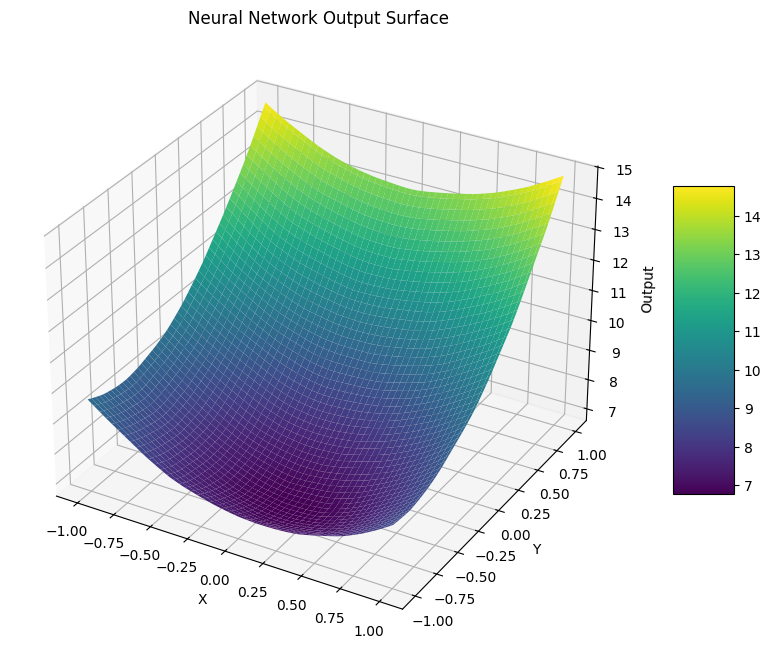

In [58]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch

# Assuming you have a trained PyTorch model called 'model'
# that takes 2D input and produces 1D output

# Create the input grid
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)
X, Y = np.meshgrid(x, y)

# Prepare the input for the model
grid = np.column_stack((X.ravel(), Y.ravel()))

# Convert to PyTorch tensor
grid_tensor = torch.tensor(grid, dtype=torch.float32)

# Get predictions from the model
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    Z = model(grid_tensor)

# Convert back to numpy for plotting
Z = Z.numpy().reshape(X.shape)

# Create the 3D plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surface = ax.plot_surface(X, Y, Z, cmap='viridis')

# Add a color bar
fig.colorbar(surface, shrink=0.5, aspect=5)

# Set labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Output')
ax.set_title('Neural Network Output Surface')

plt.show()